In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

sns.set()

In [2]:
df = pd.read_csv('../1_Data/datasets/from2018.csv')

In [3]:
df = df[['Date', 'RT_Demand', 'RT_LMP']].sort_values('Date')
df

,Date,RT_Demand,RT_LMP
0,2018-01-01 01:00:00,15521.098,146.39
19,2018-01-01 02:00:00,15069.608,134.27
15,2018-01-01 03:00:00,14780.596,133.55
16,2018-01-01 04:00:00,14659.693,141.81
17,2018-01-01 05:00:00,14744.025,136.80
...,...,...,...
43806,2022-12-31 20:00:00,13191.898,26.36
43807,2022-12-31 21:00:00,12575.713,25.38
43804,2022-12-31 22:00:00,11983.841,31.80
43821,2022-12-31 23:00:00,11381.525,44.29


In [4]:
df['Date'] = pd.to_datetime(df['Date'] )

In [5]:
df = df.set_index('Date')

In [6]:
train_size = int(len(df) * 0.9) 
train, test = df[['RT_Demand', 'RT_LMP']].iloc[:train_size], df[['RT_Demand', 'RT_LMP']].iloc[train_size:]

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

n_forecast = 24  
n_splits = 5     

metrics_lmp = {'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}

for i in range(n_splits):
    train_size = int(len(df) * (0.9 - (i * 0.02)))  # Gradually reduce training size
    train, test = df.iloc[:train_size], df.iloc[train_size:train_size + n_forecast]

    # forecast demand using ARIMA(2, 1, 2)
    model_demand = SARIMAX(train['RT_Demand'], order=(2, 1, 2))
    model_demand_fit = model_demand.fit(disp=False)
    forecast_demand = model_demand_fit.forecast(steps=n_forecast)
    
    # forecast LMP usginSARIMA(1, 0, 1)
    model_lmp = SARIMAX(train['RT_LMP'], exog=train[['RT_Demand']], order=(1, 0, 1))
    model_lmp_fit = model_lmp.fit(disp=False)
    forecast_lmp = model_lmp_fit.get_forecast(steps=n_forecast, exog=pd.DataFrame(forecast_demand, index=test.index))

    actual_lmp = test['RT_LMP'].values
    predicted_lmp = forecast_lmp.predicted_mean
    
    if i == n_splits - 1:
        last_actual_lmp = actual_lmp
        last_predicted_lmp = predicted_lmp

    metrics_lmp['MAE'].append(mean_absolute_error(actual_lmp, predicted_lmp))
    metrics_lmp['MSE'].append(mean_squared_error(actual_lmp, predicted_lmp))
    metrics_lmp['RMSE'].append(rmse(actual_lmp, predicted_lmp))
    metrics_lmp['R2'].append(r2_score(actual_lmp, predicted_lmp))

avg_metrics_lmp = {metric: np.mean(values) for metric, values in metrics_lmp.items()}

print("Average metrics for RT_LMP forecasting using predicted RT_Demand:")
print(avg_metrics_lmp)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dat

Average metrics for RT_LMP forecasting using predicted RT_Demand:
{'MAE': 35.95142387907216, 'MSE': 2956.3999611555178, 'RMSE': 44.200247460630465, 'R2': -2.3952284849887375}


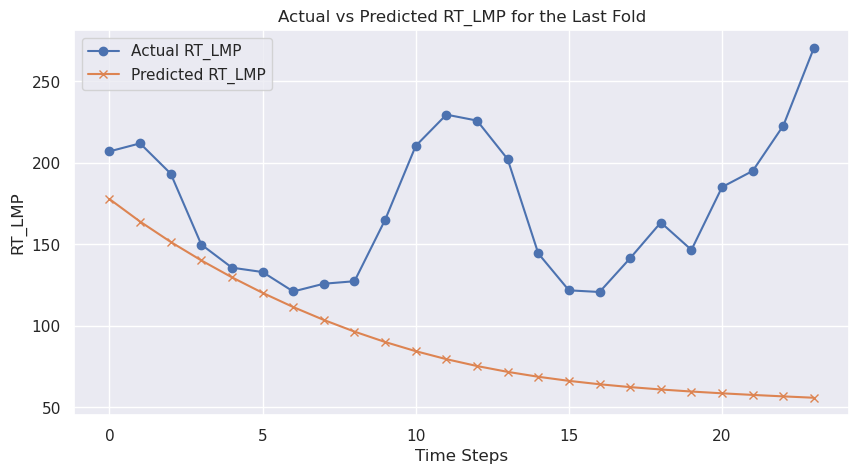

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(n_forecast), last_actual_lmp, label='Actual RT_LMP', marker='o')
plt.plot(range(n_forecast), last_predicted_lmp, label='Predicted RT_LMP', marker='x')
plt.title('Actual vs Predicted RT_LMP for the Last Fold')
plt.xlabel('Time Steps')
plt.ylabel('RT_LMP')
plt.legend()
plt.show()

The results you've provided for the SARIMA model predicting RT_LMP using forecasted RT_Demand as an exogenous variable show that there is still substantial room for improvement. The metrics indicate that the model's predictions are relatively inaccurate.

Let' try other more comlex model cascades